# Avoiding unphysical loss in low-index-contrast waveguides

When working with low-index-contrast waveguides, such as SiN embedded in SiO₂, the optical field can become highly delocalized, especially in narrow structures such as the tip of an edge coupler, resulting in a large mode field size. In such cases, it's important to carefully define the mode plane to prevent extended evanescent fields from reaching the Perfectly Matched Layer (PML), as this can lead to unphysical losses and inaccurate simulation results.

In this notebook, we will demonstrate how an insufficiently large plane size can result in unphysical losses.

We will also demonstrate how to assemble a [`ModeSolver`](https://lumopt.readthedocs.io/en/latest/Advanced_Usage.html#modesolver) simulation to quickly determine whether the simulation plane is large enough. Furthermore, we will illustrate how to create a grid to efficiently run a simulation with a sufficiently large plane size.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Defining the Geometry

In [2]:
# global parameters
wl = 1.5
num_freqs = 1

freq0 = td.C_0 / wl
fwidth = 0.2 * freq0
freqs = [freq0] if num_freqs == 1 else np.linspace(freq0 - fwidth, freq0 + fwidth, num_freqs)

source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)

symmetry = [0, 1, -1]

sim_center = (0, 0, 0)

run_time = 20e-12

In [3]:
# function for returning the waveguide as a function of length and plane size
def get_sim(length=10, plane_size=6, min_steps_per_wvl=15):
    sim_size = (length, plane_size, plane_size)

    structure_index = 1.99
    background_index = 1.44

    width = 0.33
    height = 0.2

    structure_medium = td.Medium(permittivity=structure_index**2)
    background_medium = td.Medium(permittivity=background_index**2)

    structure = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(td.inf, width, height)), medium=structure_medium
    )

    # source
    mode_spec = td.ModeSpec(num_modes=1, precision="double")

    source = td.ModeSource(
        center=(-sim_size[0] / 2 + 0.5, 0, 0),
        size=(0, plane_size, plane_size),
        mode_spec=mode_spec,
        direction="+",
        mode_index=0,
        source_time=source_time,
    )
    # flux monitor
    flux_mon = td.FluxMonitor(
        name="flux_mon",
        size=(0, plane_size, plane_size),
        center=(sim_size[0] / 2 - 0.5, 0, 0),
        freqs=freqs,
    )
    # field monitor
    field_mon = td.FieldMonitor(
        name="field_mon",
        size=(td.inf, td.inf, 0),
        center=(0, 0, 0),
        freqs=freqs,
    )

    # grid spec
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl)

    sim = td.Simulation(
        size=sim_size,
        center=sim_center,
        grid_spec=grid_spec,
        structures=[structure],
        sources=[source],
        monitors=[flux_mon, field_mon],
        run_time=run_time,
        symmetry=symmetry,
        medium=background_medium,
    )

    ms = ModeSolver(
        mode_spec=source.mode_spec.updated_copy(num_pml=(12, 12)),
        freqs=freqs,
        simulation=sim,
        plane=td.Box(size=(0, plane_size, plane_size), center=source.center),
    )

    return sim, ms

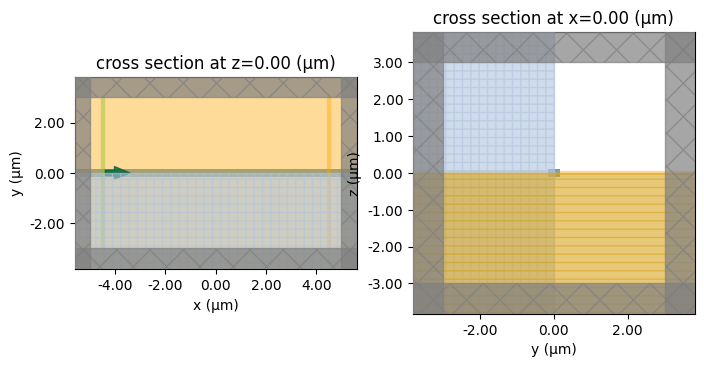

In [4]:
# plotting the simulation domain

sim, _ = get_sim()

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
sim.plot(ax=ax[0], z=0)
sim.plot(ax=ax[1], x=0)

plt.show()

## Mode Solver Analysis

First, we will carry out `ModeSolver` simulations varying the plane size.

In [5]:
ms_list = {}
sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

for size in sizes:
    _, ms = get_sim(5, plane_size=size)
    ms_list[size] = ms

ms_batch = web.Batch(simulations=ms_list)
ms_data = ms_batch.run()

Output()

09:59:30 UTC Started working on Batch containing 14 tasks.

09:59:44 UTC Maximum FlexCredit cost: 0.135 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

10:06:05 UTC Batch complete.

Output()

Now, we can plot the imaginary part of the effective index as a function of the plane size. As we can see, for planes smaller than 60 µm, there are losses induced by the interaction of the evanescent fields with the simulation boundaries. These losses will lead to unphysical results for a long waveguide.

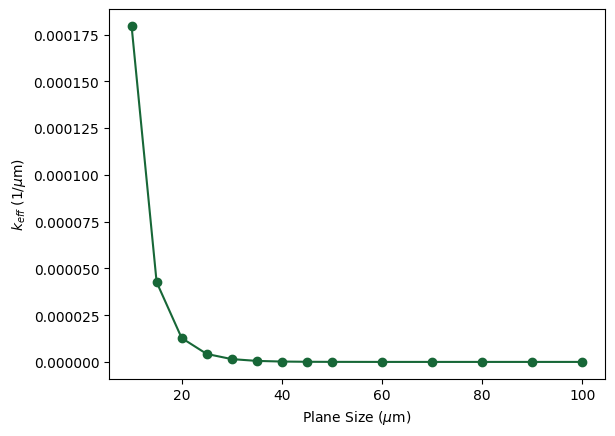

In [6]:
loss = [ms_data[str(i)].to_dataframe()["k eff"] for i in sizes]

fig, ax = plt.subplots()
ax.set_xlabel(r"Plane Size ($\mu$m)")
ax.set_ylabel(r"$k_{eff}$ (1/$\mu$m)")

ax.plot(sizes, loss, "-o")

plt.show()

To illustrate the importance of a correct simulation domain size, we compare the mode profiles for plane sizes of 20 µm and 80 µm.

As we can see, in the 20 µm case, the fields extending into the PML are not negligible. In contrast, with an 80 µm plane size, the fields decay sufficiently before reaching the PML boundaries.

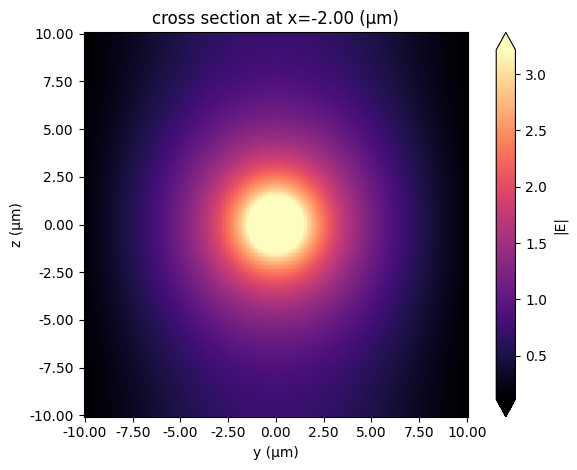

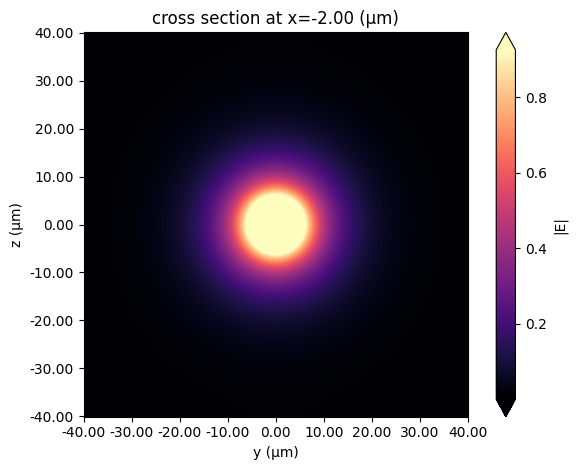

In [7]:
ms_list[20].plot_field("E", "abs")
ms_list[80].plot_field("E", "abs")

plt.show()

## FDTD Simulation

Now, we will simulate a relatively long waveguide with two different plane sizes: 10 µm and 60 µm. We will add `FluxMonitors` every 20 µm and observe the losses as a function of propagation.

In [8]:
sim_10, _ = get_sim(length=150, plane_size=10)
sim_60, _ = get_sim(length=150, plane_size=60)

monitors = []
positions = range(20, 150, 20)
for i in positions:
    flux_mon = td.FluxMonitor(
        name=f"flux_mon{i}",
        size=(0, 50, 50),
        center=(-sim_10.size[0] / 2 + i, 0, 0),
        freqs=freqs,
    )

    monitors.append(flux_mon)

sim_10 = sim_10.updated_copy(monitors=monitors + [sim_10.monitors[-1]])
sim_60 = sim_60.updated_copy(monitors=sim_10.monitors)


batch = web.Batch(simulations={10: sim_10, 60: sim_60})

In [9]:
batch_data = batch.run()

Output()

10:10:34 UTC WARNING: Mode source at sources[0] has a large number (7.57e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

10:10:38 UTC Started working on Batch containing 2 tasks.

10:10:40 UTC Maximum FlexCredit cost: 29.441 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

10:12:53 UTC Batch complete.

Output()

As we can see, for the 10 µm plane size simulation, there are significant losses, although increasing the simulation size can significantly raise the simulation cost.

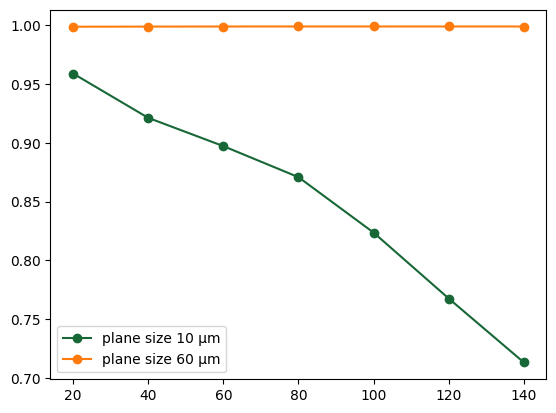

In [10]:
fig, ax = plt.subplots()

loss_10 = [batch_data["10"][f"flux_mon{i}"].flux for i in positions]
loss_60 = [batch_data["60"][f"flux_mon{i}"].flux for i in positions]

ax.plot(positions, loss_10, "o-", label="plane size 10 µm")
ax.plot(positions, loss_60, "o-", label="plane size 60 µm")

ax.legend()
plt.show()

In [11]:
cost_60 = web.real_cost(batch_data.task_ids["60"])
cost_10 = web.real_cost(batch_data.task_ids["10"])
print(f"Cost for plane size 10: {cost_10}")
print(f"Cost for plane size 60: {cost_60}")

10:15:24 UTC Billed flex credit cost: 2.789.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

             Billed flex credit cost: 0.155.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

Cost for plane size 10: 0.1548042128079098
Cost for plane size 60: 2.7893188716153694


## Custom Grid for Reducing Simulation Cost

To reduce simulation cost, we can use the minimum permitted value for the autogrid `min_steps_per_wavelength` argument, which is 6, and add a MeshOverrideRegion around the waveguide. This allows enough space for the fields to decay before reaching the simulation boundaries, while maintaining good resolution around the waveguide.


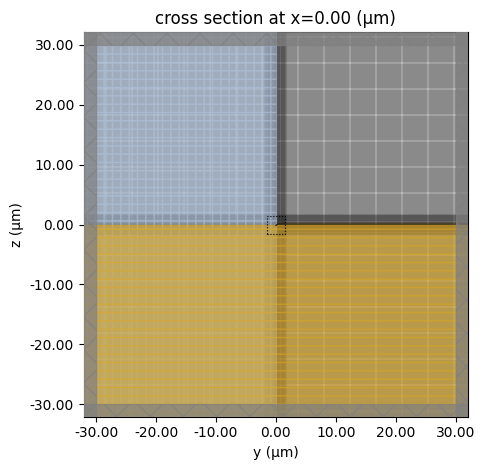

In [12]:
mesh_structure = sim_60.structures[0]

Si02_steps = (wl / 1.45) / 15
SiN_steps = (wl / 1.99) / 15

mesh_override_SiN = td.MeshOverrideStructure(
    geometry=mesh_structure.geometry,
    dl=(SiN_steps,) * 3,
)


mesh_override_SiO2 = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 3, 3)),
    dl=(Si02_steps,) * 3,
)


grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=6, override_structures=[mesh_override_SiO2, mesh_override_SiN]
)

sim_60_newMesh = sim_60.updated_copy(grid_spec=grid_spec)

ax = sim_60_newMesh.plot(x=0)
sim_60_newMesh.plot_grid(ax=ax, x=0)

plt.show()

In [13]:
sim_data = web.run(sim_60_newMesh, "sim_60_newMesh")

10:15:25 UTC WARNING: Mode source at sources[0] has a large number (1.46e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             Created task 'sim_60_newMesh' with task_id                         
             'fdve-d0c479bb-c804-4ae0-ae81-72b049845151' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=314411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=928883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\taskId]8;;\]8;id=314411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\=]8;;\]8;id=496631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\fdve]8;;\]8;id=314411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\-d0c479bb-c80]8;;\
             ]8;id=314411;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\4-4ae0-ae81-72b049845151']8;;\.

             Task folder: ]8;id=958309;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

10:15:27 UTC Maximum FlexCredit cost: 7.807. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

10:15:29 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:15:34 UTC status = preprocess

10:15:56 UTC starting up solver

10:15:57 UTC running solver

Output()

10:16:33 UTC early shutoff detected at 8%, exiting.

             status = postprocess

Output()

10:16:36 UTC status = success

10:16:38 UTC View simulation result at                                          
             ]8;id=241657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=110890;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\taskId]8;;\]8;id=241657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\=]8;;\]8;id=987286;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\fdve]8;;\]8;id=241657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\-d0c479bb-c80]8;;\
             ]8;id=241657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d0c479bb-c804-4ae0-ae81-72b049845151\4-4ae0-ae81-72b049845151']8;;\.

Output()

10:16:42 UTC loading simulation from simulation_data.hdf5

In [14]:
# Here we will use the web API get_tasks to get the cost of the last simulation

cost_60_newMesh = web.real_cost(web.get_tasks(1)[0]["task_id"])
print(f"Cost for plane size 60 with new mesh: {cost_60_newMesh}")

10:17:43 UTC WARNING: No connection: Retrying for 180 seconds.                  

10:19:52 UTC ERROR: No internet connection: giving up on connection waiting.    

WebError: No internet connection: giving up on connection waiting.

As we can see, this meshing strategy returns very similar results, while consuming less than one-third of the Flexcredits.

In [ ]:
loss_60_newMesh = [sim_data[f"flux_mon{i}"].flux for i in positions]

fig, ax = plt.subplots()
ax.plot(positions, loss_10, label="plane size 10 µm")
ax.plot(positions, loss_60, label="plane size 60 µm")
ax.plot(positions, loss_60_newMesh, "o", label="plane size 60 µm - new mesh")
ax.legend()

plt.show()